In [1]:
import os
import os.path
import numpy as np
import scipy.linalg as spl
from scipy import stats
import scipy.io as sio
import matplotlib.pyplot as plt

/home/nicogravel/anaconda3/envs/py36/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%javascript
function toggler(){
    if(window.already_toggling){
        // Don't add multiple buttons.
        return 0
    }
    let btn = $('.input').append('<button>Toggle Code</button>')
        .children('button');
    btn.on('click', function(e){
        let tgt = e.currentTarget;
        $(tgt).parent().children('.inner_cell').toggle()
    })
    window.already_toggling = true;
}
// Since javascript cells are executed as soon as we load
// the notebook (if it's trusted), and this cell might be at the
// top of the notebook (so is executed first), we need to
// allow time for all of the other code cells to load before
// running. Let's give it 5 seconds.

setTimeout(toggler, 5000);

<IPython.core.display.Javascript object>

# Permutation test

Based on this: https://github.com/ColeLab/MultipleComparisonsPermutationTesting/blob/master/pythonCode/permutationTesting.py

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 14 14:11:32 2020
@author: mattwint
"""

def perm(X, Y, perms=1000, test='rel', alpha=.05, nan='propagate'):
    """Takes two equally shaped sets of data and performs a 2 sample permutation 
    T-test. This test can handel nan values, so if your sampels are not equal 
    in size you can inset nan's were needed. Data can be 1, 2, 3, or 4 
    dimensions. Data sets can either be arrays, up to 4 dimension, or the 
    outermost dimesion can be a list.
    Args:
        X: first data set where the first dimension is the observations.
        Y: second data set where the first dimension is the observations.
        perms:  the number of times to permute the data, typically 1000 or greater.
        alpha: significance value for the probability of rejecting the null hypothesis
            when it is true. Typically set at 0.05.
    Returns: 
        Global: array of T values where the observed T values were larger than 1-alpha% of 
            all the null permuted data. Best for data that is 1D or 2D unless 
            you want separate comparisons for each index. 
        Part: array of T values where the observed T value was larger than the permuted
            T distributions in the same index point of the array. Very conservative, observed 
            values must be greater than All permuted values in the same index point.
        P_array: array showing p values where the observed t values exceeded 1-alpha% 
            of the permuted values at each index point of a multidimensional array. 
            Typical permutation test output, best for multidimensional data where index matters. 
        null_Tmax: The single T value from the permuted null distribution that is above 1-alpha 
        t_score: array of T values from the observed data.
        nullT: list of arrays of T values from the permuted data.
        max_null: identify outliers in null permuted data after ttest
        max_obs: identify outliers in observed data after ttest
        """
    
    from scipy.stats.mstats import mquantiles
    import numpy as np
        
    if np.array(X).shape != np.array(Y).shape:
        raise ValueError('datasets have diffrent dimensions')
    
    dims = len(np.array(X).shape) # find dimensions of data

##################### 4 dimensions to data ####################################
    if dims == 4:
        _, dim1, dim2, dim3 = np.array(X).shape
        t_score = np.zeros((dim1,dim2,dim3))      

    ##### test real data ######
        for i in range(dim1):
            which_subs = ~np.isnan(np.array(X)[:, i, 0, 0])
            samp1 = np.array(X)[which_subs, i, :, :]
            samp2 = np.array(Y)[which_subs, i, :, :]
            
            diff = samp1 - samp2
            n_sub = diff.shape[0]
            t_score[i, :, :] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))
   
    ## set up data sets to be permuted over perms times##    
        nullT=[]
        null_count=np.zeros((dim1,dim2,dim3))

        for iteration in range(perms):
            permA=np.copy(X)
            permB=np.copy(Y)
            for a in range(len(permA)):    
    ### create dummy permutation of 1s & 0s in a dim1 x dim2 x dim3 array ###         
                perm_frame = np.random.randint(0,2,size=(dim1,dim2,dim3))
        ###### seperate permuted data into two artifical groups A and B ######
                permA[a]=perm_frame
                permB[a]=perm_frame
        
    #### replace dummy code with the condition data ####
                permA[a]=np.where(permA[a]==0, X[a], Y[a])
                permB[a]=np.where(permB[a]==0, Y[a], X[a])
                
    ##### t-test permuted data conditions A & B ####
            t_perms = np.zeros((dim1,dim2,dim3))
            
            for i in range(dim1):
                which_subs = ~np.isnan(np.array(X)[:, i, 0, 0])
                perm1 = permA[which_subs, i, :, :]
                perm2 = permB[which_subs, i, :, :]
                
                diff = perm1 - perm2
                n_sub = diff.shape[0]
                t_perms[i, :, :] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub)) 
                  
    # store values from each of the 1000 iterations to create Tmax distribution #
            nullT.append(t_perms)
            
    ##### get p values across all dimentions. 
        null_count=np.zeros((perms,dim1,dim2,dim3))
        for i in range(perms):
            null_count[i]=nullT[i]>=t_score

        null_count=np.sum(null_count, axis=0)
    
        P_val=null_count/perms  
        P_array = np.where(P_val<alpha, P_val,np.nan)
        
    ##### identify Tmax in the permuted data #####
        null_Tmax=mquantiles(np.array(nullT).max((1,2,3)), 1-alpha)
        
        ###identify outliers 
        max_null=np.max(nullT)
        max_obs=np.max(t_score)       

    #####compare observed diffrences vs Tmax permuted diffrences ######
        # index by index difference #
        Part=np.zeros((dim1,dim2,dim3))
        TorF = t_score[np.newaxis, :, :, :] > nullT
        mask = TorF.sum(0) == perms
        Part[mask] = t_score[mask]
        Part[mask == False] = np.nan
    
        # Global difference #    
        Global=np.zeros((dim1,dim2,dim3))
        mask = t_score > null_Tmax
        Global[mask] = t_score[mask]
        Global[mask == False] = np.nan

############ 3 dimension to data ##############################################
    elif dims == 3:
        _, dim1, dim2 = np.array(X).shape
        t_score = np.zeros((dim1,dim2))      

    ##### test real data ######
        for i in range(dim1):
            which_subs = ~np.isnan(np.array(X)[:, i, 0])
            samp1 = np.array(X)[which_subs, i, :]
            samp2 = np.array(Y)[which_subs, i, :]
            
            diff = samp1 - samp2
            n_sub = diff.shape[0]
            t_score[i, :] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))
   
    ## set up data sets to be permuted over perms times##    
        nullT=[]
        null_count=np.zeros((dim1,dim2))
        
        for iteration in range(perms):
            permA=np.copy(X)
            permB=np.copy(Y)
            for a in range(len(permA)):    
    
        ### create dummy permutation of 1s & 0s in a dim1 x dim2 x dim3 array ###        
                perm_frame = np.random.randint(0,2,size=(dim1,dim2))
                
        ###### seperate permuted data into two artifical groups A and B ######
                permA[a]=perm_frame
                permB[a]=perm_frame
        
    #### replace dummy code with the condition data ####
                permA[a]=np.where(permA[a]==0, X[a], Y[a])
                permB[a]=np.where(permB[a]==0, Y[a], X[a])
          
    ##### t-test permuted data conditions A & B ####
            t_perms = np.zeros((dim1,dim2))
            
            for i in range(dim1):
                which_subs = ~np.isnan(np.array(X)[:, i, 0])
                perm1 = permA[which_subs, i, :]
                perm2 = permB[which_subs, i, :]
                
                diff = perm1 - perm2
                n_sub = diff.shape[0]
                t_perms[i, :] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))    
                
    # store values from each of the 1000 iterations to create Tmax distribution #
            nullT.append(t_perms)

    ##### get p values across all dimentions. 
        null_count=np.zeros((perms,dim1,dim2))
        for i in range(perms):
            null_count[i]=nullT[i]>=t_score

        null_count=np.sum(null_count, axis=0)
    
        P_val=null_count/perms  
        P_array = np.where(P_val<alpha, P_val,np.nan)
        
    ##### identify Tmax in the permuted data #####
        null_Tmax=mquantiles(np.array(nullT).max((1,2)), 1-alpha)
        
        ###identify outliers 
        max_null=np.max(nullT)
        max_obs=np.max(t_score)       

    #####compare observed diffrences vs Tmax permuted diffrences ######
        # index by index difference #
        Part=np.zeros((dim1,dim2))
        TorF = t_score[np.newaxis, :, :] > nullT
        mask = TorF.sum(0) == perms
        Part[mask] = t_score[mask]
        Part[mask == False] = np.nan
    
        # Global difference #    
        Global=np.zeros((dim1,dim2))
        mask = t_score > null_Tmax
        Global[mask] = t_score[mask]
        Global[mask == False] = np.nan
        
########### 2 dimensions to data ############################################## 
    elif dims == 2:
        _, dim1 = np.array(X).shape
        t_score = np.zeros((dim1))      

    ##### test real data ######
        for i in range(dim1):
            which_subs = ~np.isnan(np.array(X)[:, i])
            samp1 = np.array(X)[which_subs, i]
            samp2 = np.array(Y)[which_subs, i]
            
            diff = samp1 - samp2
            n_sub = diff.shape[0]
            t_score[i] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))
   
    ## set up data sets to be permuted over perms times##    
        nullT=[]
        null_count=np.zeros((dim1))
        
        for iteration in range(perms):
            permA=np.copy(X)
            permB=np.copy(Y)
            for a in range(len(permA)):    
                
    ### create dummy permutation of 1s & 0s in a dim1 x dim2 x dim3 array ###
                perm_frame = np.random.randint(0,2,size=(dim1))
        ###### seperate permuted data into two artifical groups A and B ######
                permA[a]=perm_frame
                permB[a]=perm_frame
                
    #### replace dummy code with the condition data ####
                permA[a]=np.where(permA[a]==0, X[a], Y[a])
                permB[a]=np.where(permB[a]==0, Y[a], X[a])
   
    ##### t-test permuted data conditions A & B ####
            t_perms = np.zeros((dim1,dim2))
            
            for i in range(dim1):
                which_subs = ~np.isnan(np.array(X)[:, i, 0])
                perm1 = permA[which_subs, i]
                perm2 = permB[which_subs, i]
                
                diff = perm1 - perm2
                n_sub = diff.shape[0]
                t_perms[i] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))                   
    
    # store values from each of the 1000 iterations to create Tmax distribution #
            nullT.append(t_perms)
            
    ##### get p values across all dimentions. 
        null_count=np.zeros((perms,dim1))
        for i in range(perms):
            null_count[i]=nullT[i]>=t_score

        null_count=np.sum(null_count, axis=0)
    
        P_val=null_count/perms  
        P_array = np.where(P_val<alpha, P_val,np.nan)
        
    ##### identify Tmax in the permuted data #####
        null_Tmax=mquantiles(np.array(nullT).max((1)), 1-alpha)
        
        ###identify outliers 
        max_null=np.max(nullT)
        max_obs=np.max(t_score)       

    #####compare observed diffrences vs Tmax permuted diffrences ######
        # index by index difference #
        Part=np.zeros((dim1))
        TorF = t_score[np.newaxis, :] > nullT
        mask = TorF.sum(0) == perms
        Part[mask] = t_score[mask]
        Part[mask == False] = np.nan
    
        # Global difference #    
        Global=np.zeros((dim1))
        mask = t_score > null_Tmax
        Global[mask] = t_score[mask]
        Global[mask == False] = np.nan
    
############################################################################
    
    else: raise ValueError('X has to be 2 to 4 dimensional')
    return Global, Part, P_array, null_Tmax, t_score, nullT, max_obs, max_null   

# Load modeling results

In [10]:
prep_pth = '/home/nicogravel/Laminar_VisualFieldMapping/HCP_7T_prep/EVC/'
# load the results into files
FC_emp=np.load(os.path.join(prep_pth,'FC_emp.npy'))          # empirical spatiotemporal FC
mask_EC=np.load(os.path.join(prep_pth,'mask_EC.npy'))        # mask of optimized connections
mask_Sigma=np.load(os.path.join(prep_pth,'mask_Sigma.npy'))  # mask of optimized Sigma elements
J_mod=np.load(os.path.join(prep_pth,'J_mod.npy'))            # estimated Jacobian matrices,                                                 # EC + inverse time constant on diagonal
Sigma_mod=np.load(os.path.join(prep_pth,'Sigma_mod.npy'))    # estimated Sigma matrices
dist_mod=np.load(os.path.join(prep_pth,'dist_mod.npy'))      # model error
EC_normed = np.load(os.path.join(prep_pth,'EC_normed.npy'))
tau_x = np.load(os.path.join(prep_pth,'tau_x.npy'))

In [5]:
print(J_mod.shape)

(157, 10, 24, 24)


# Plot EC

In [5]:
n_sub = J_mod.shape[0]
n_ses = J_mod.shape[1]
# Subjects x Task
scans    = [i for i in range(n_sub*n_ses)]
scan_idx = np.zeros((n_ses,n_sub)).astype(np.uint)
for n in range(n_ses):
    scan = [x for x in scans if x%n_ses ==n]
    scan_idx[n,:] = scan
print('Subjects x Task :', scan_idx)
print(scan_idx[1,:])

Subjects x Task : [[   0   10   20 ... 1540 1550 1560]
 [   1   11   21 ... 1541 1551 1561]
 [   2   12   22 ... 1542 1552 1562]
 ...
 [   7   17   27 ... 1547 1557 1567]
 [   8   18   28 ... 1548 1558 1568]
 [   9   19   29 ... 1549 1559 1569]]
[   1   11   21   31   41   51   61   71   81   91  101  111  121  131
  141  151  161  171  181  191  201  211  221  231  241  251  261  271
  281  291  301  311  321  331  341  351  361  371  381  391  401  411
  421  431  441  451  461  471  481  491  501  511  521  531  541  551
  561  571  581  591  601  611  621  631  641  651  661  671  681  691
  701  711  721  731  741  751  761  771  781  791  801  811  821  831
  841  851  861  871  881  891  901  911  921  931  941  951  961  971
  981  991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111
 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251
 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391
 1401 1411 1421 1431 1441 1451 1461 1471 148

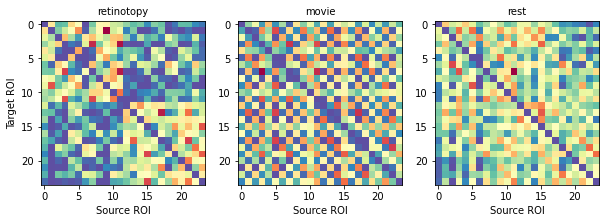

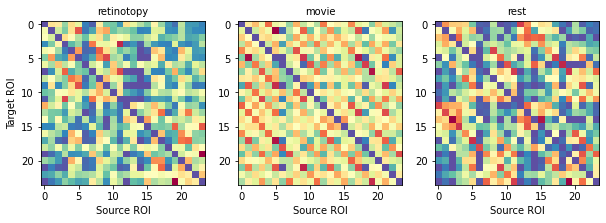

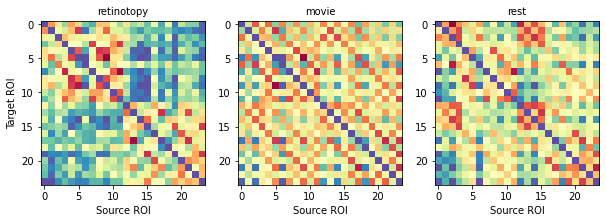

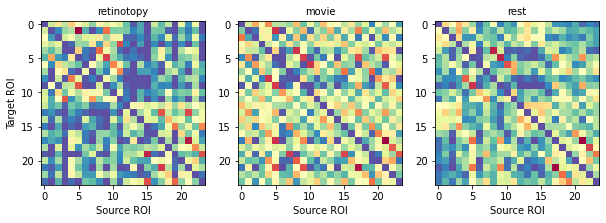

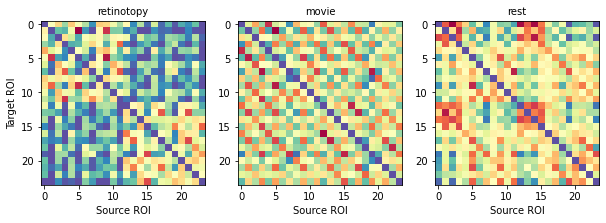

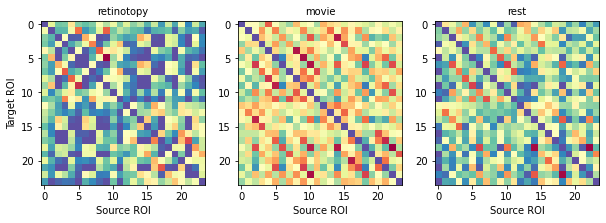

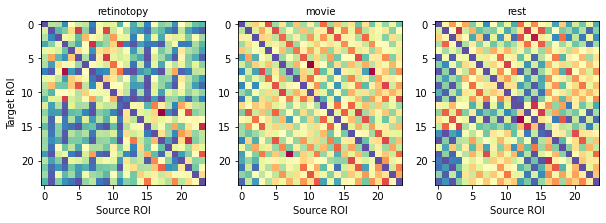

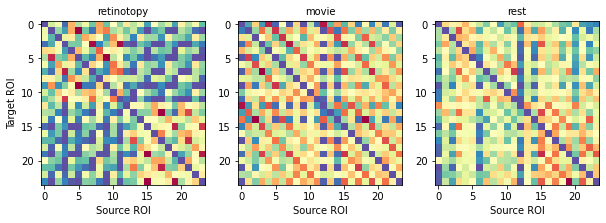

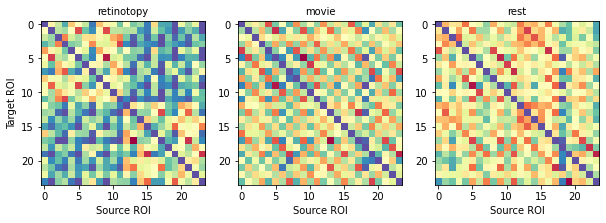

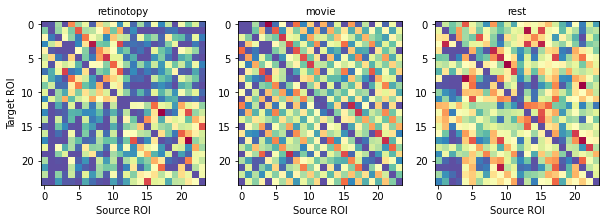

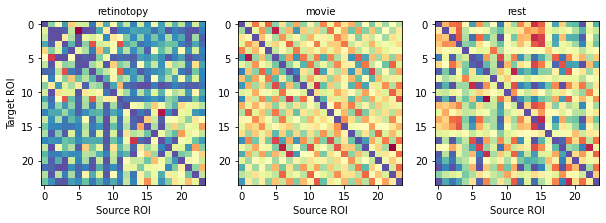

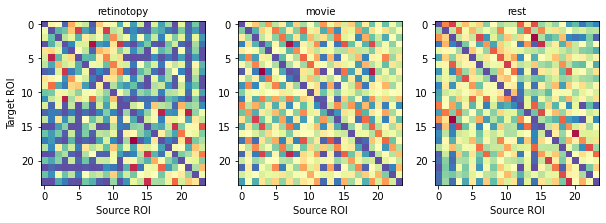

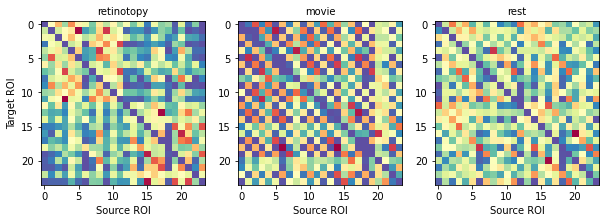

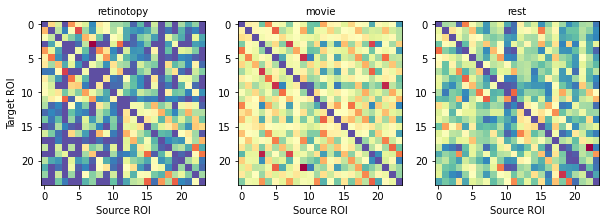

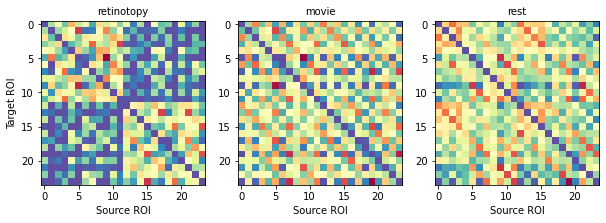

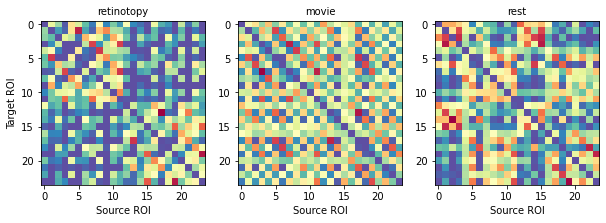

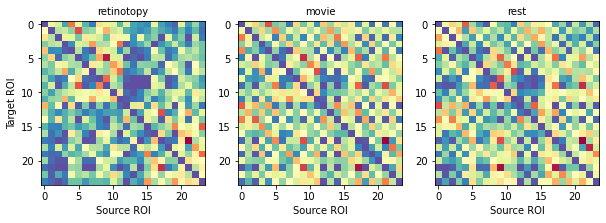

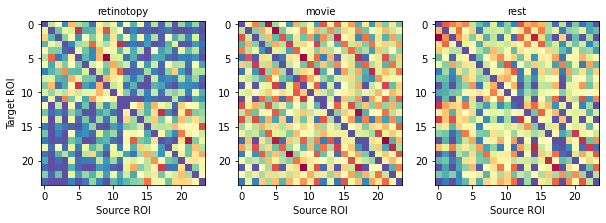

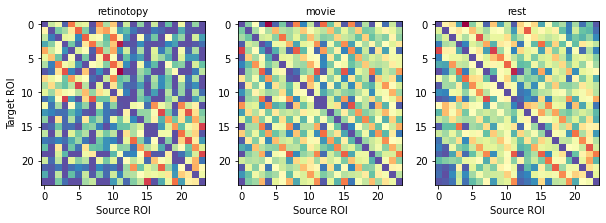

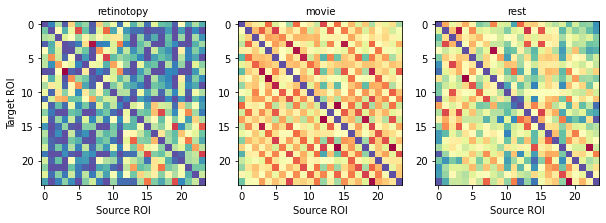

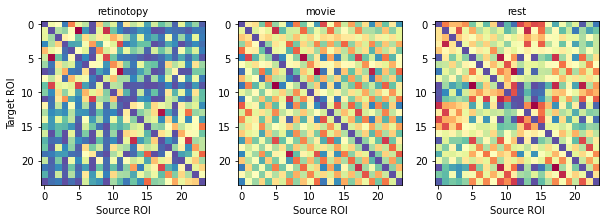

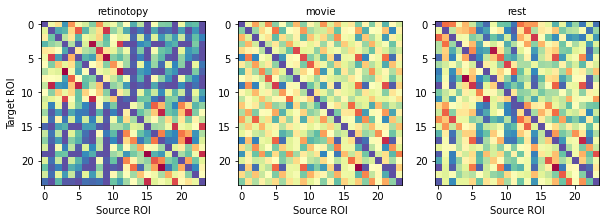

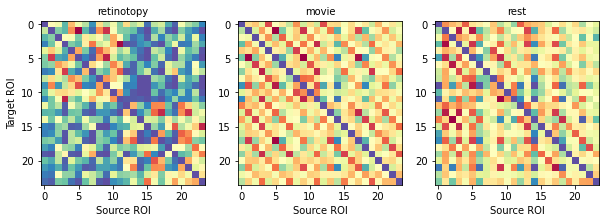

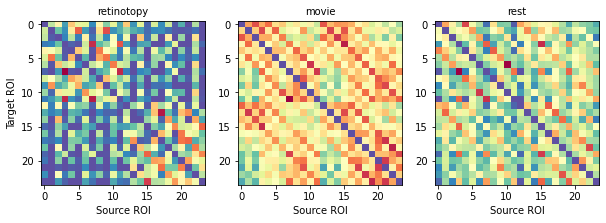

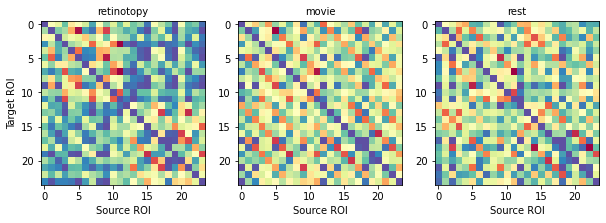

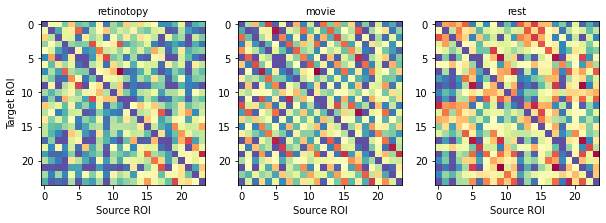

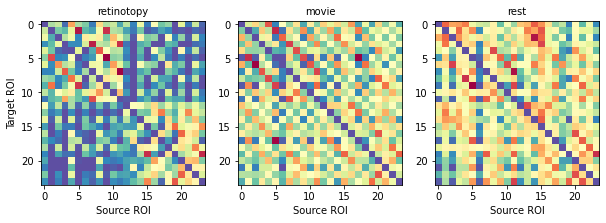

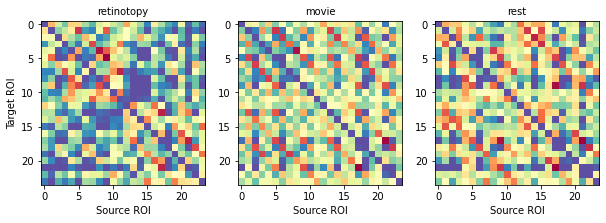

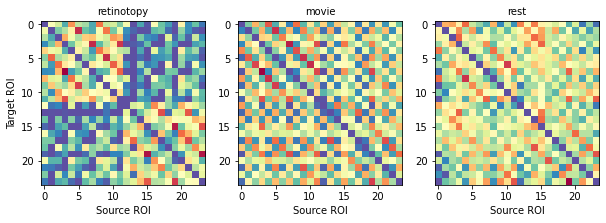

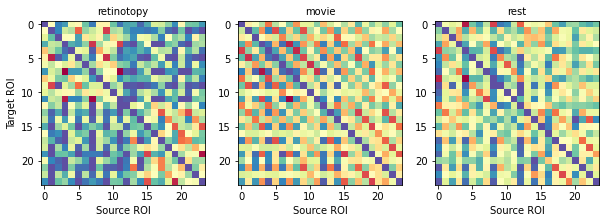

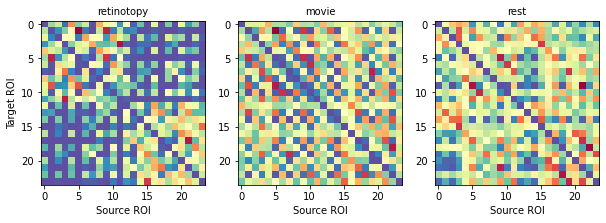

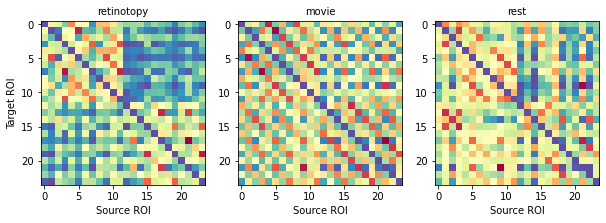

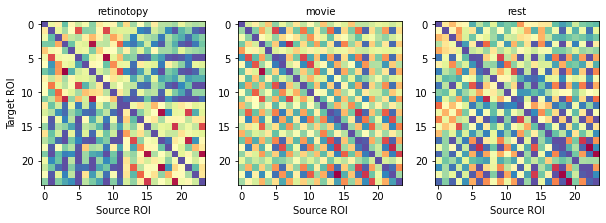

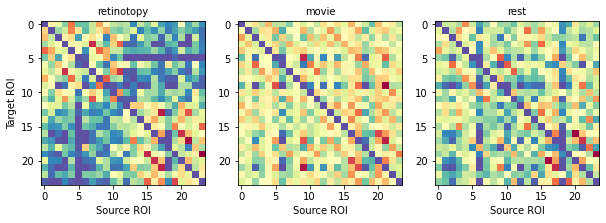

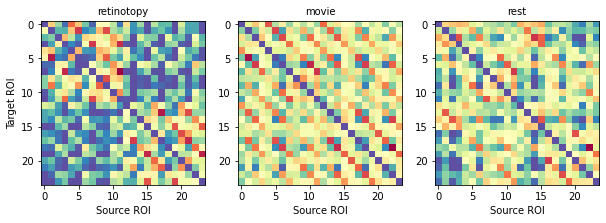

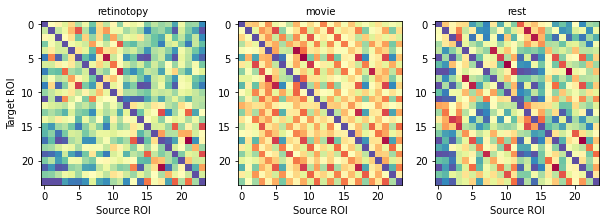

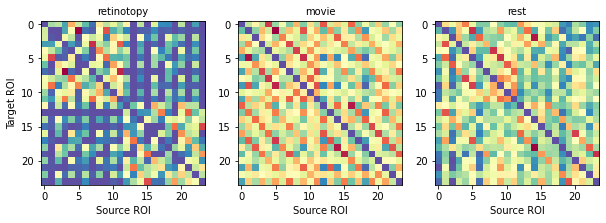

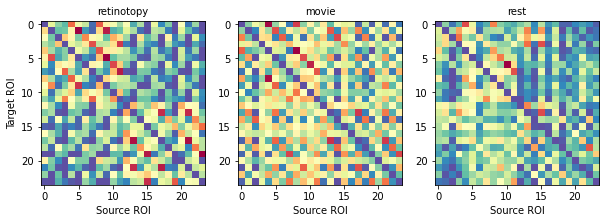

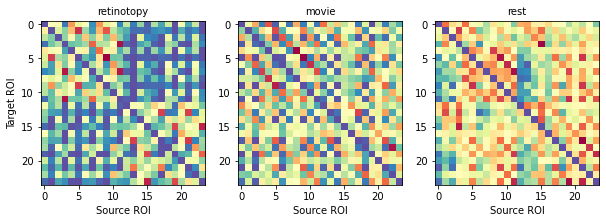

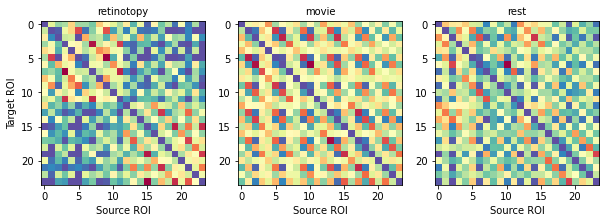

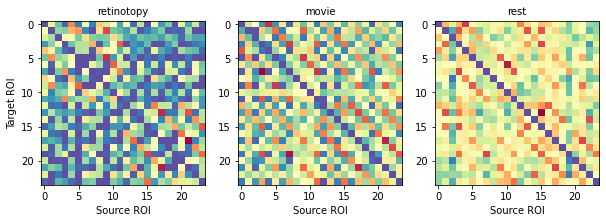

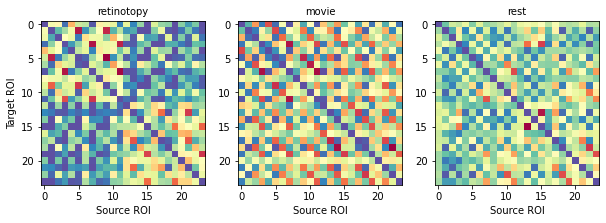

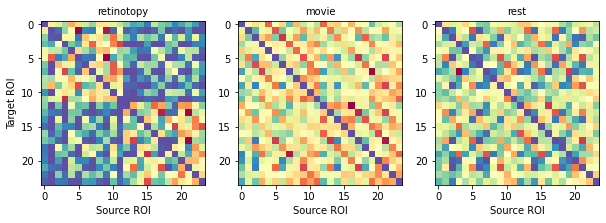

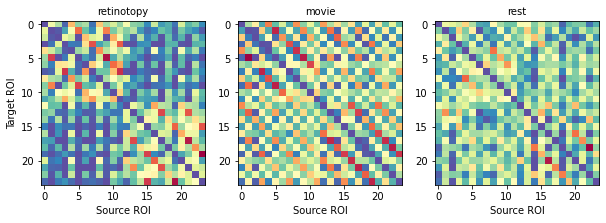

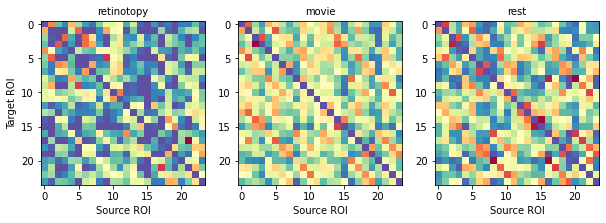

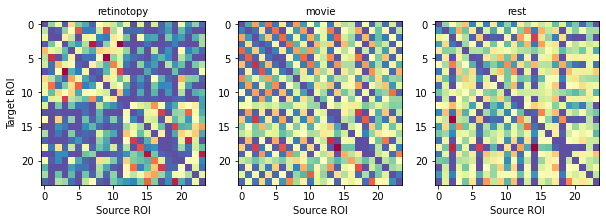

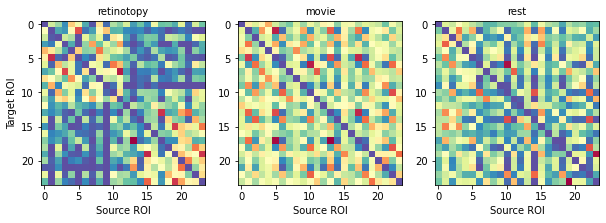

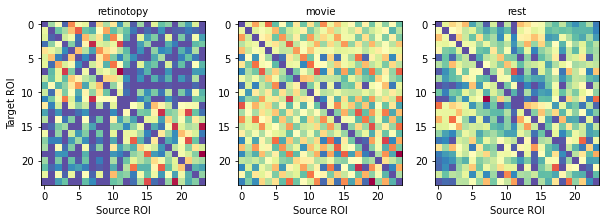

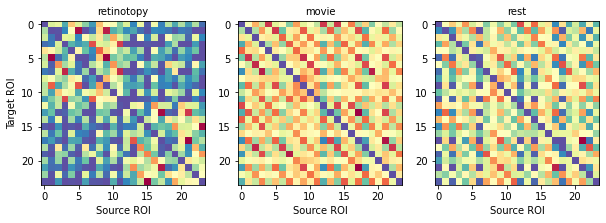

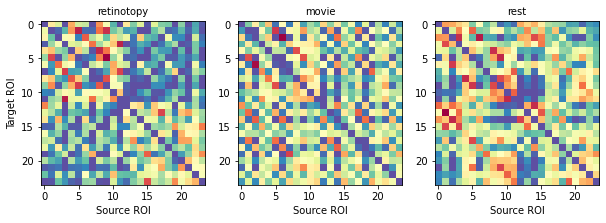

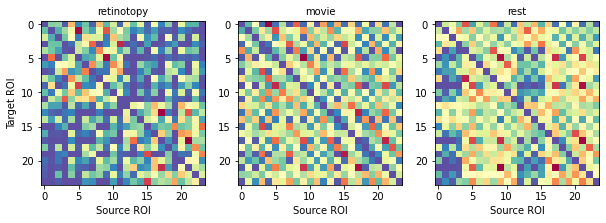

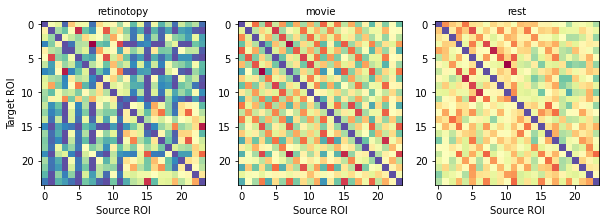

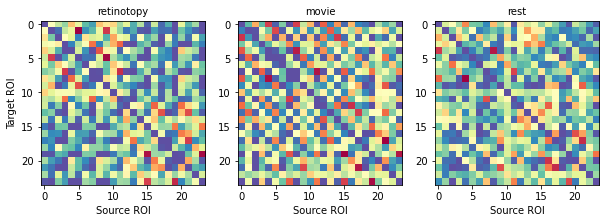

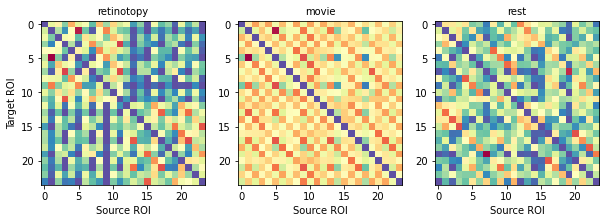

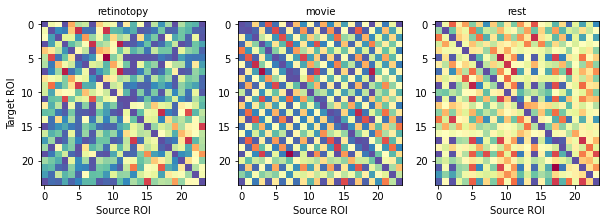

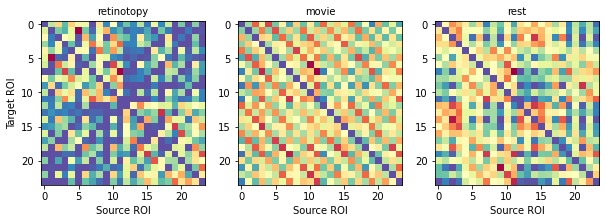

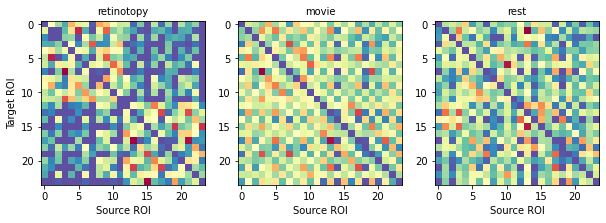

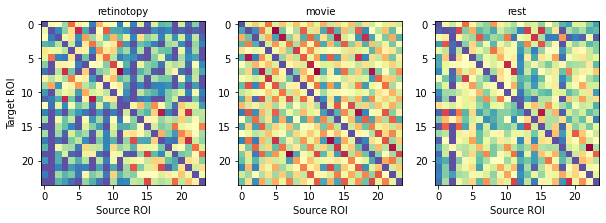

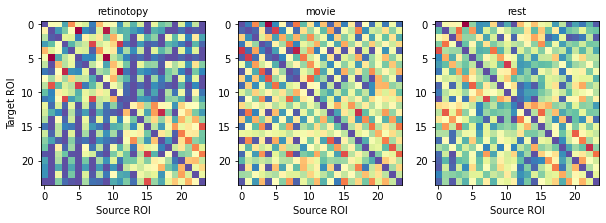

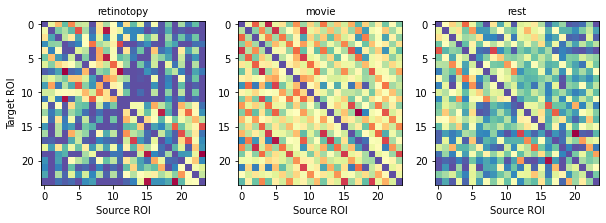

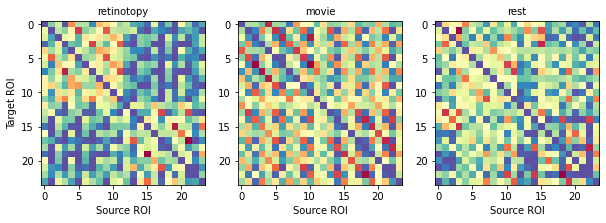

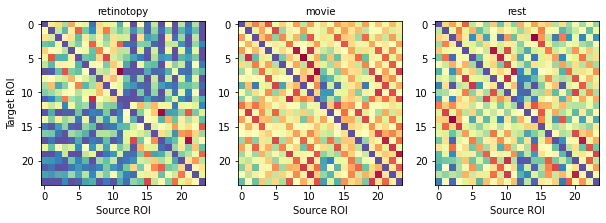

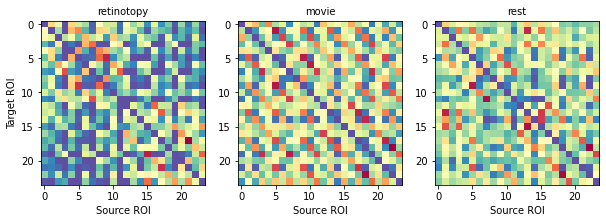

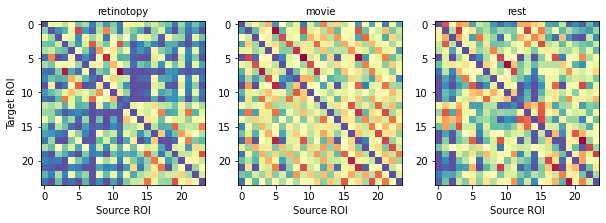

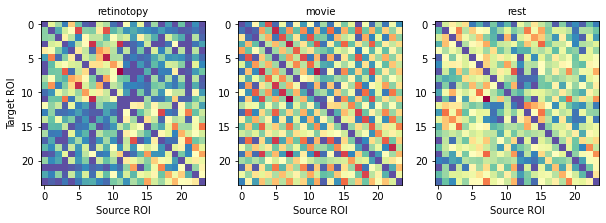

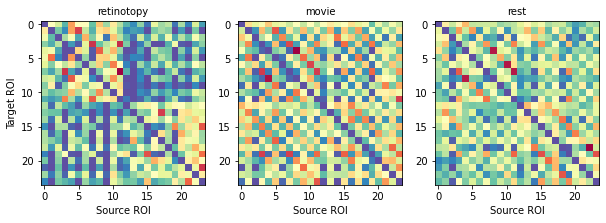

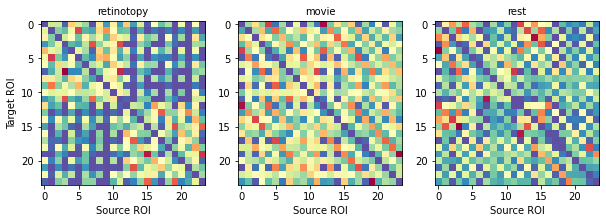

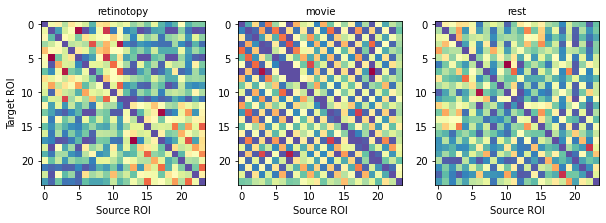

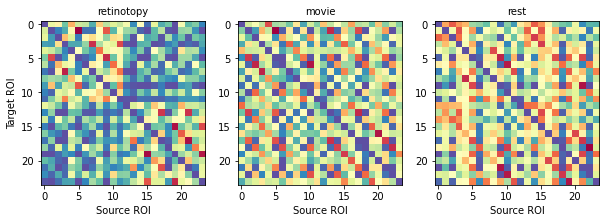

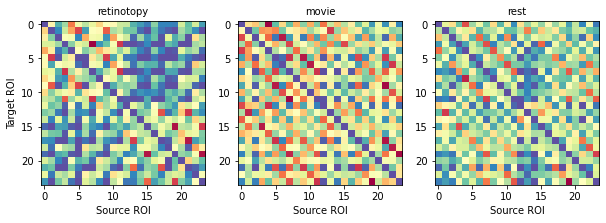

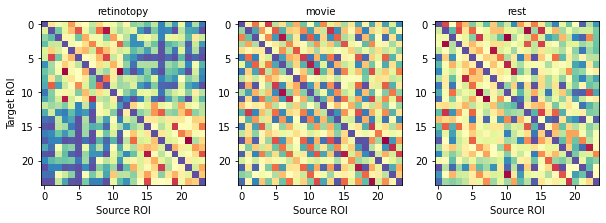

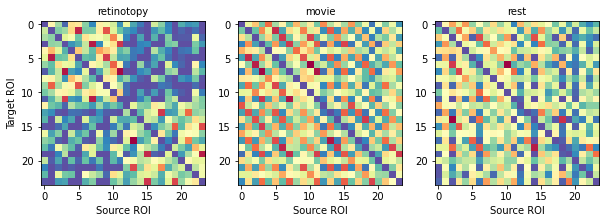

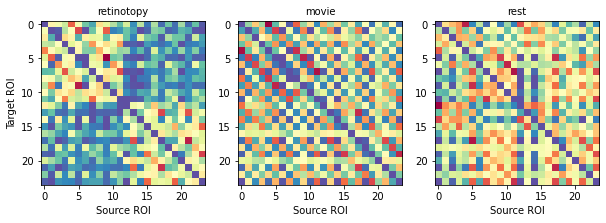

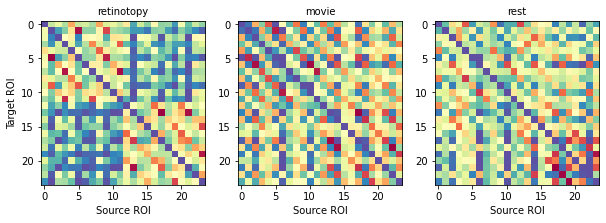

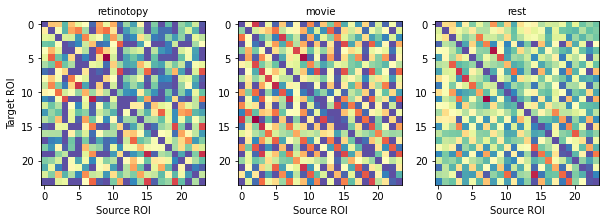

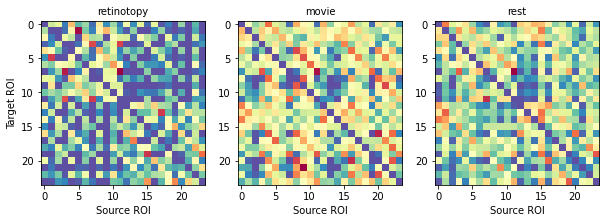

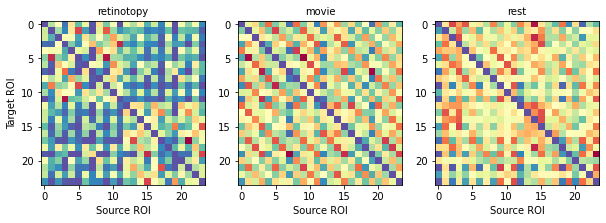

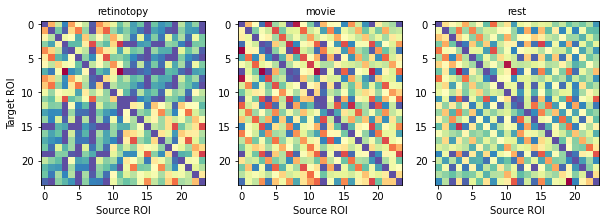

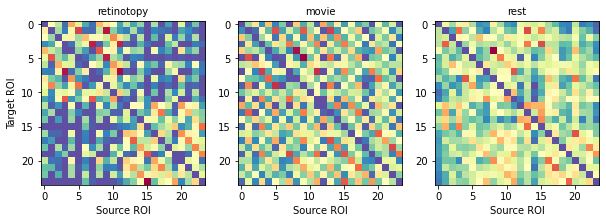

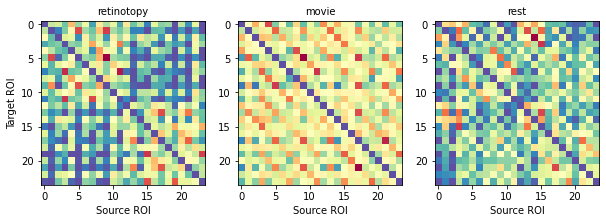

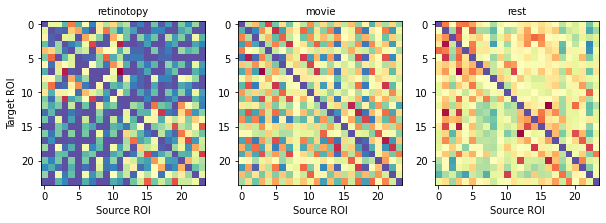

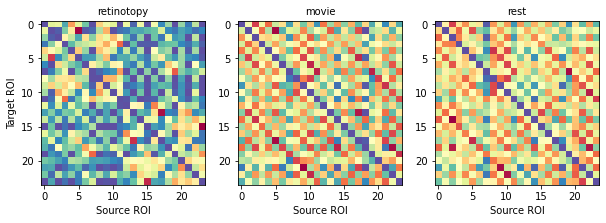

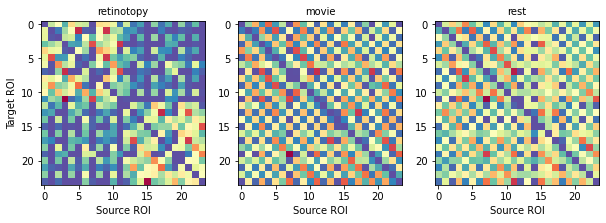

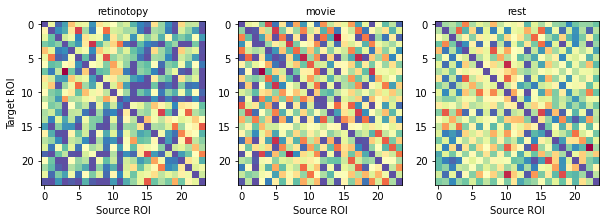

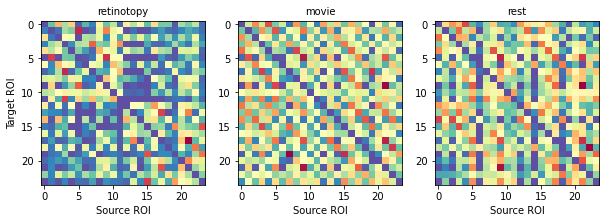

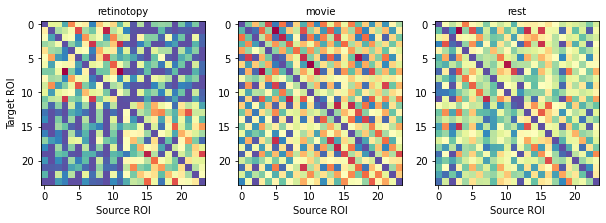

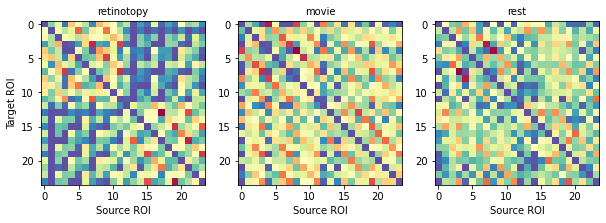

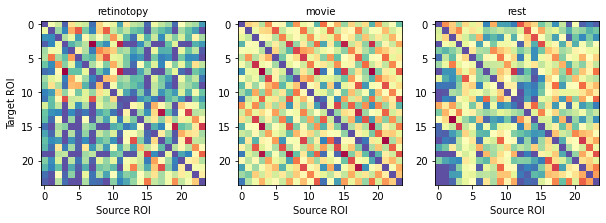

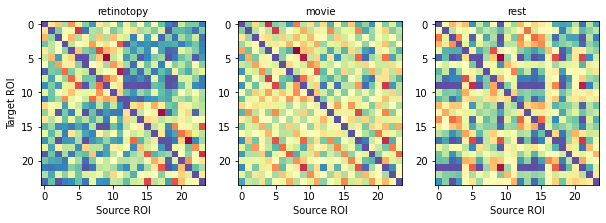

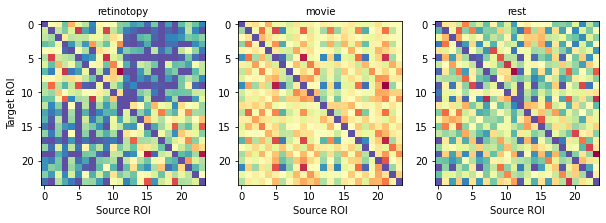

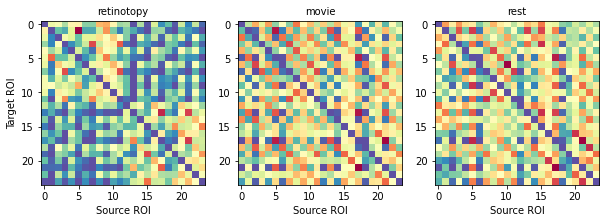

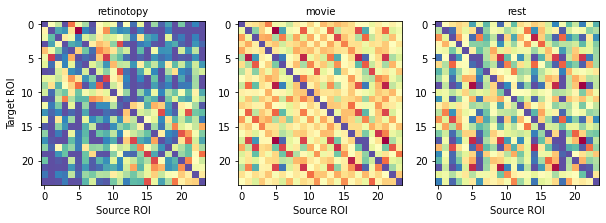

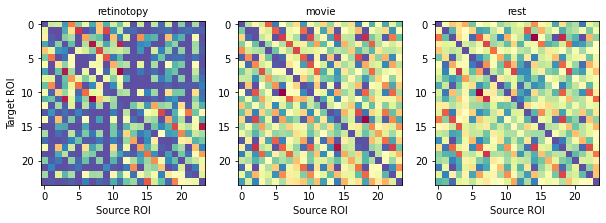

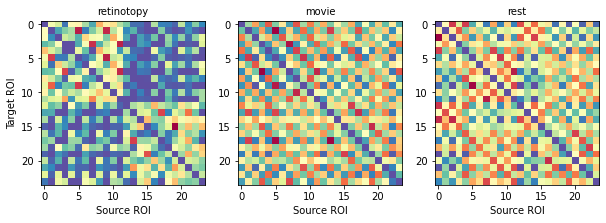

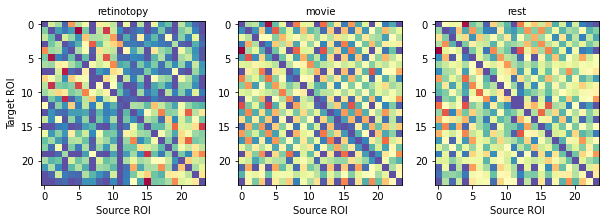

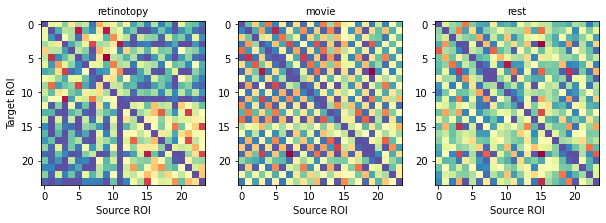

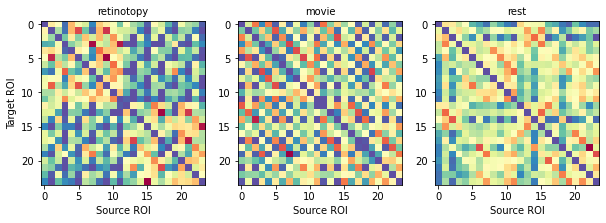

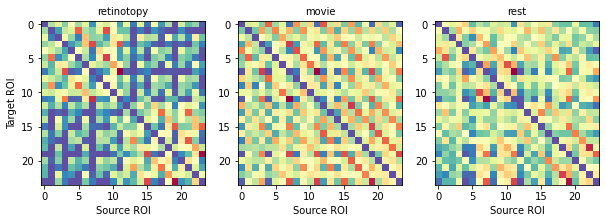

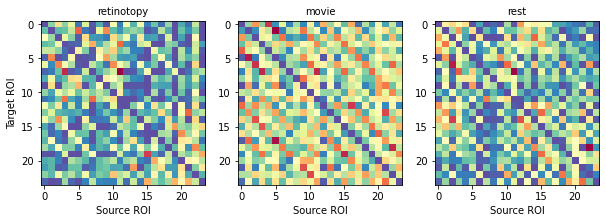

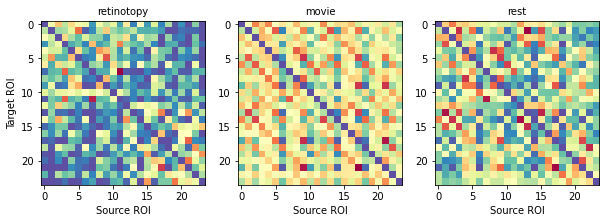

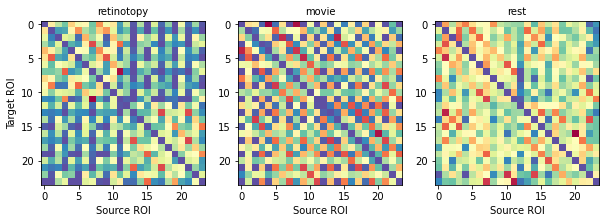

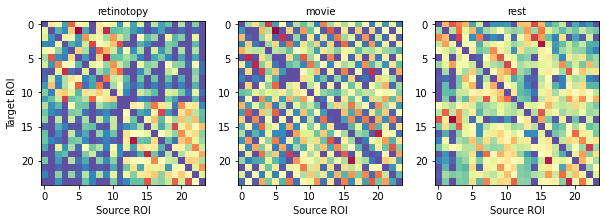

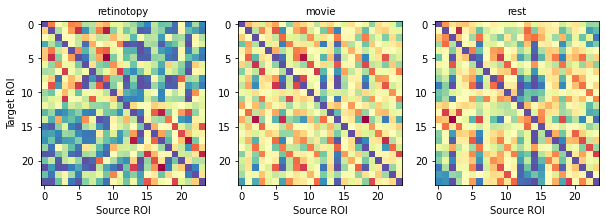

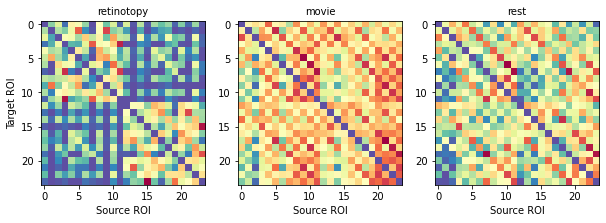

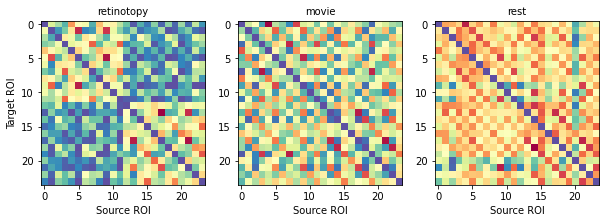

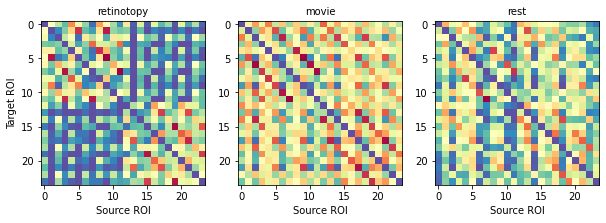

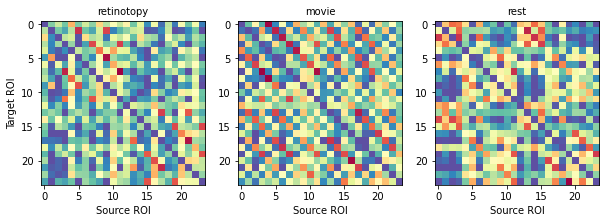

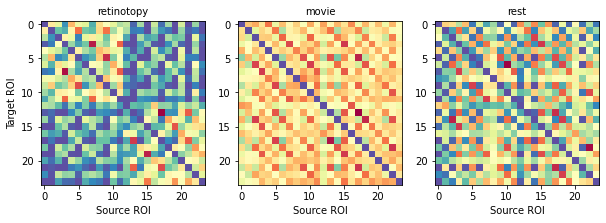

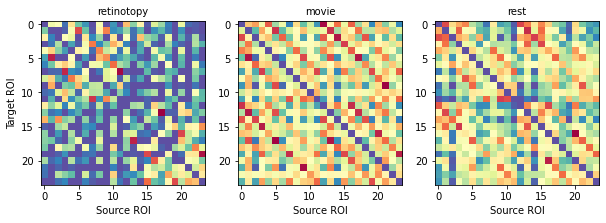

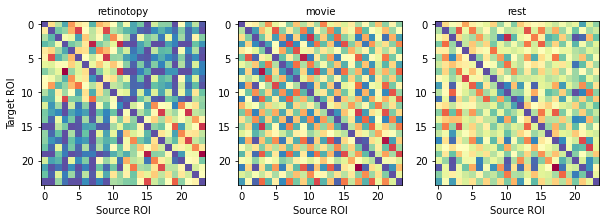

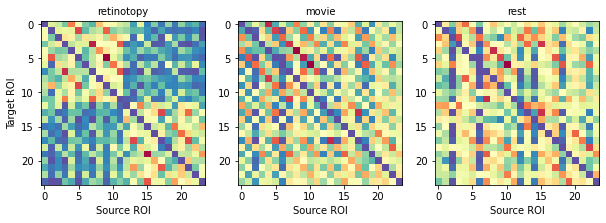

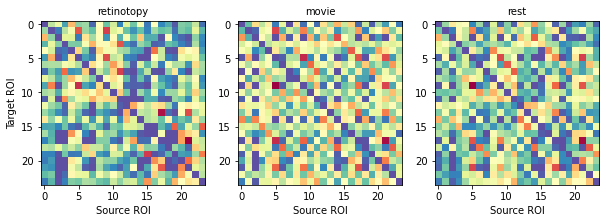

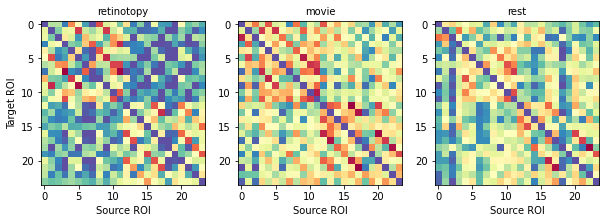

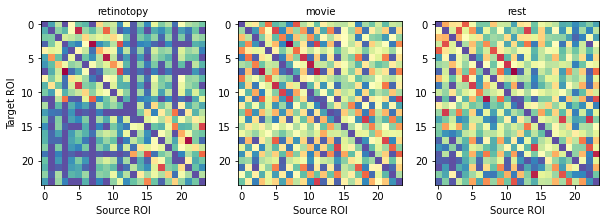

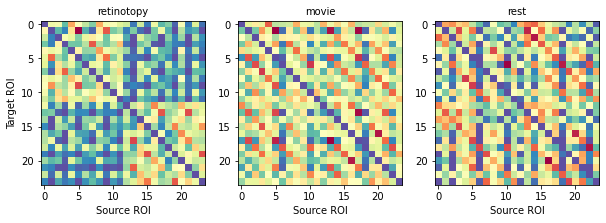

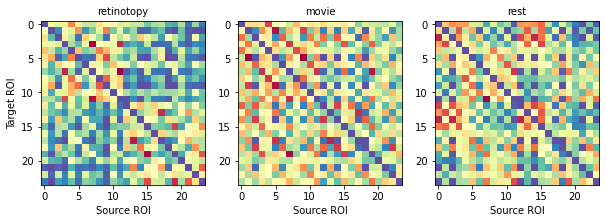

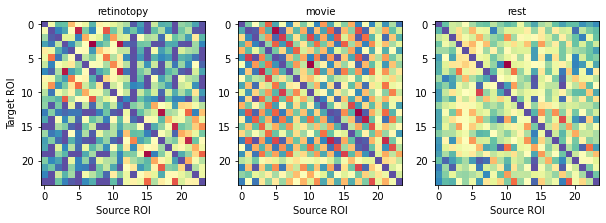

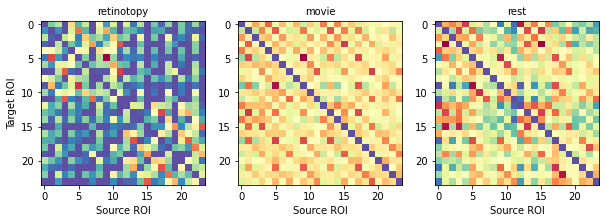

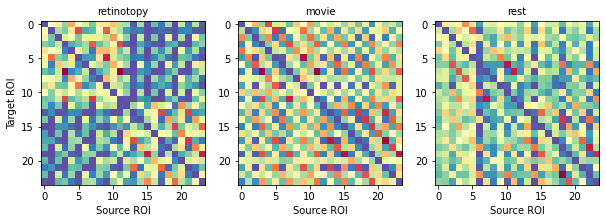

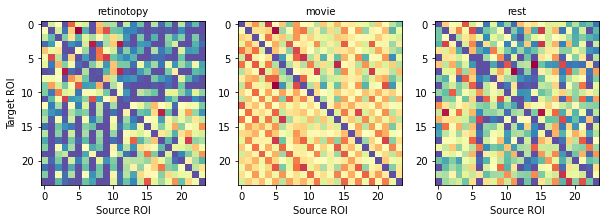

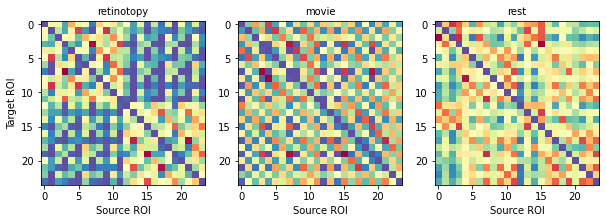

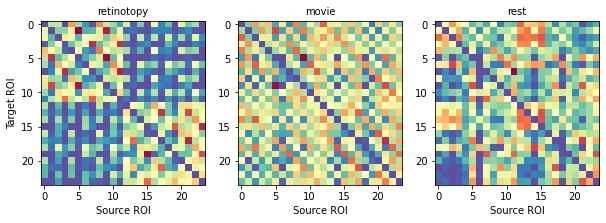

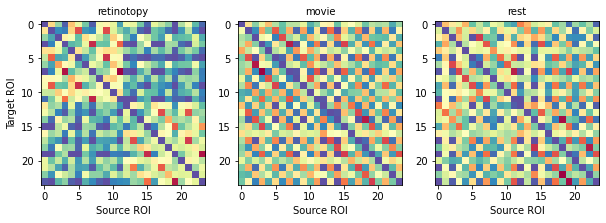

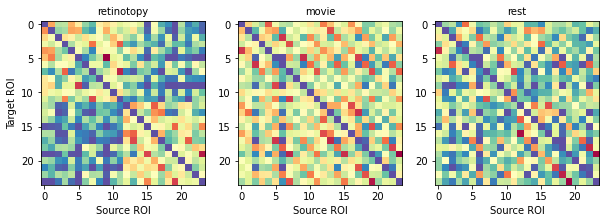

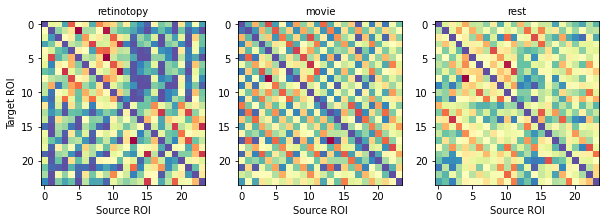

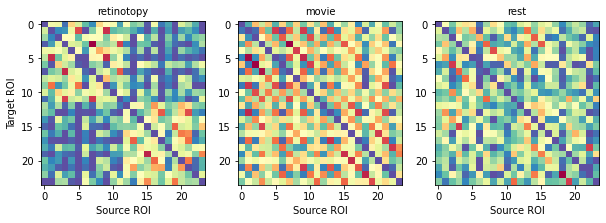

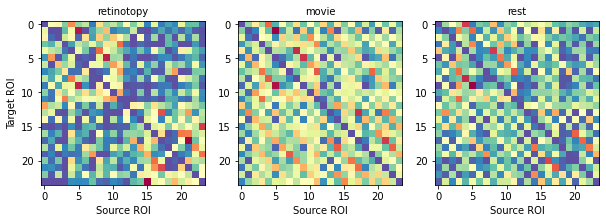

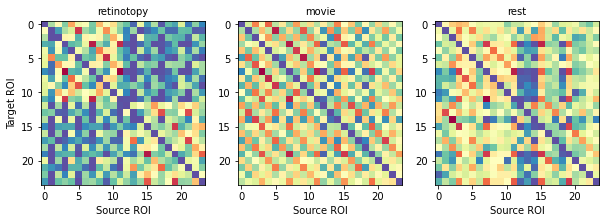

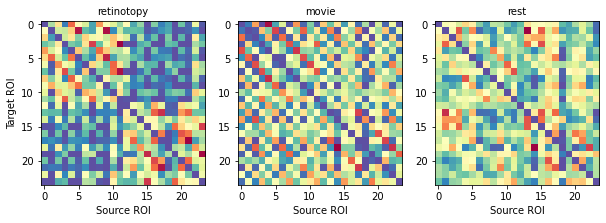

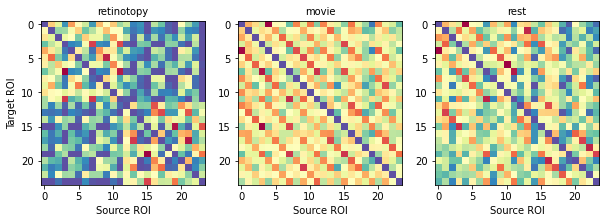

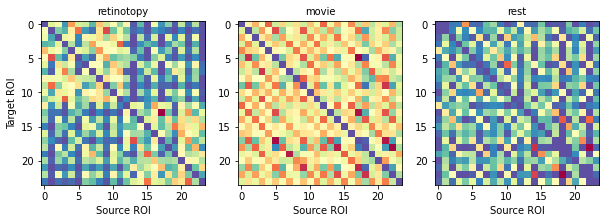

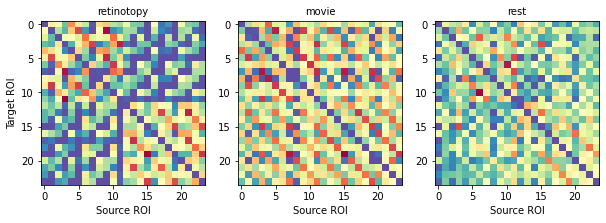

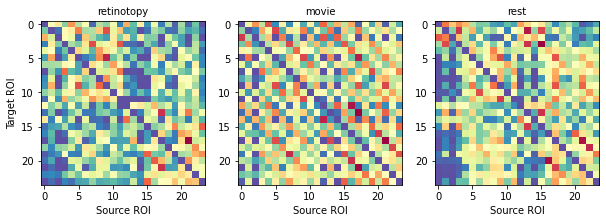

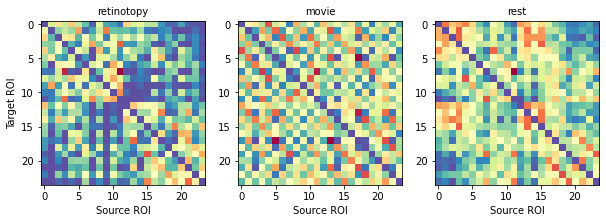

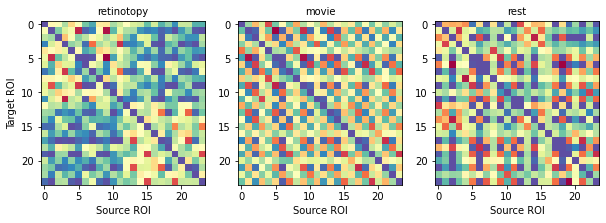

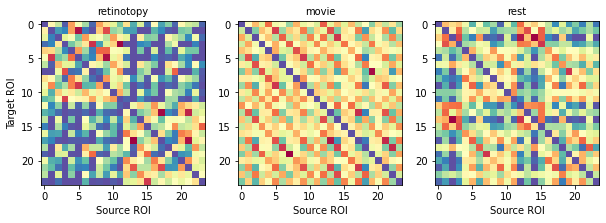

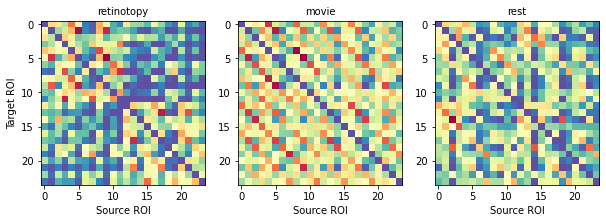

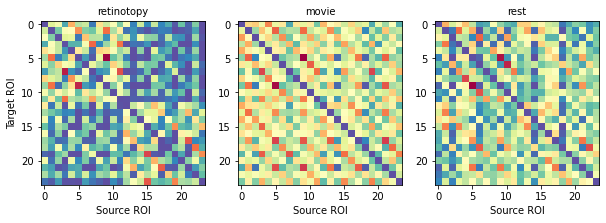

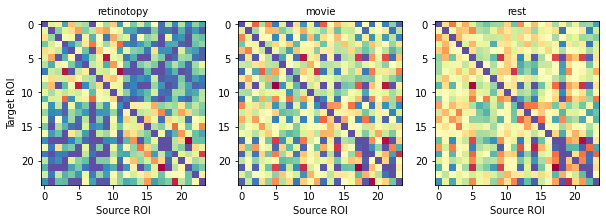

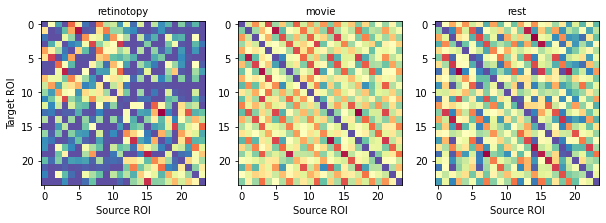

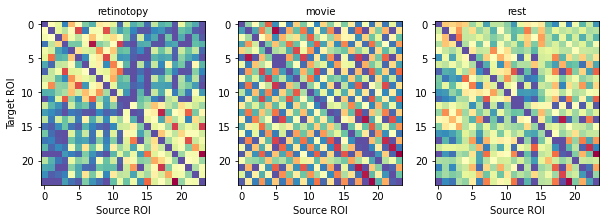

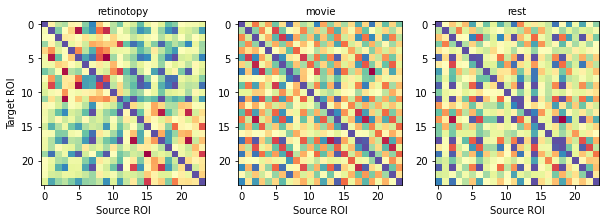

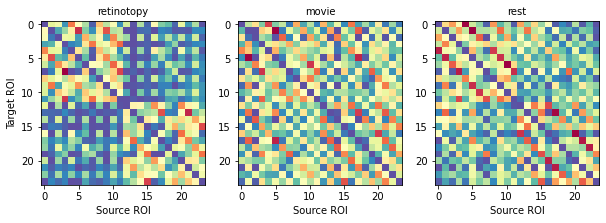

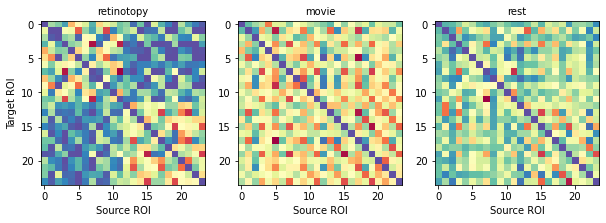

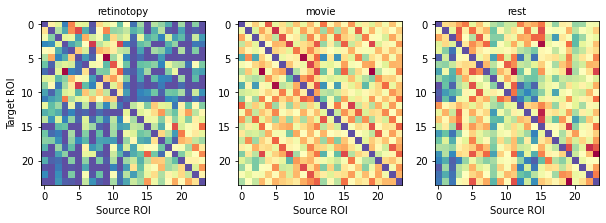

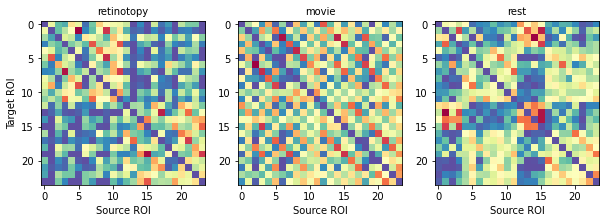

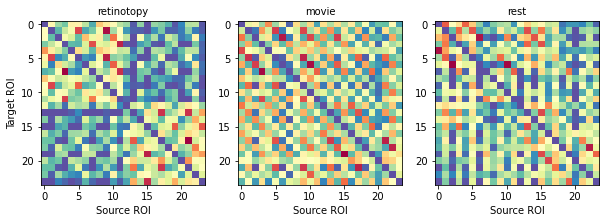

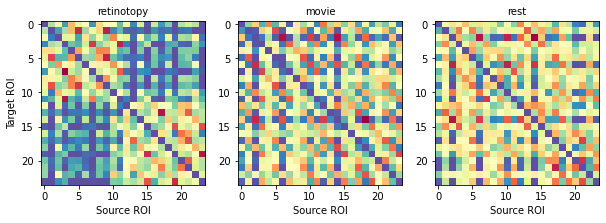

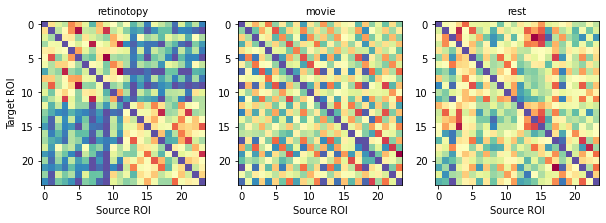

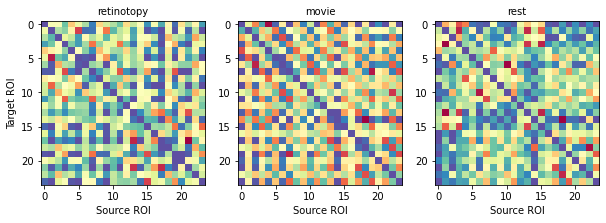

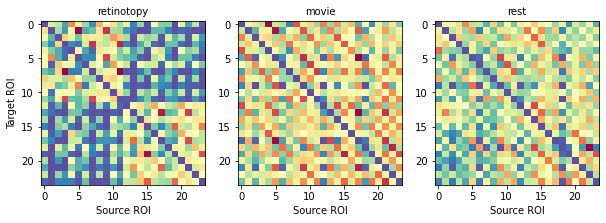

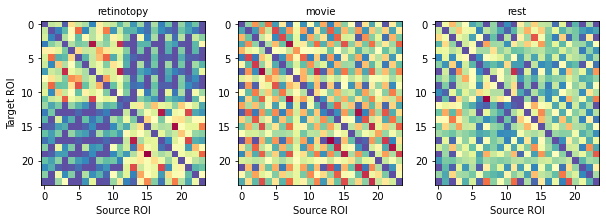

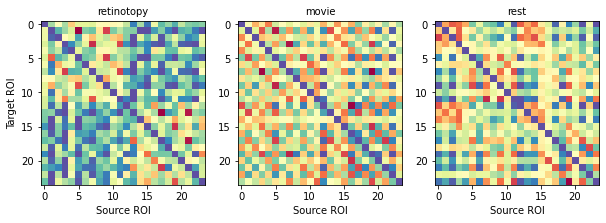

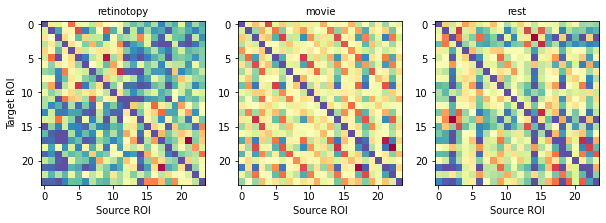

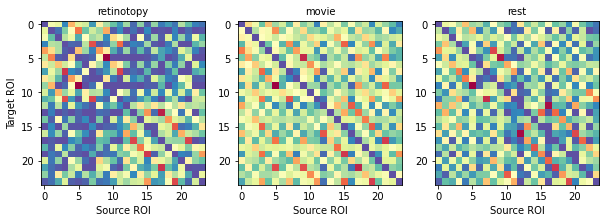

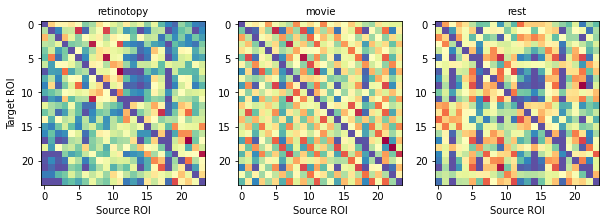

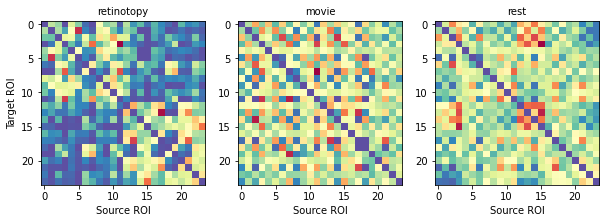

In [6]:
tsk_a = [0,1]
tsk_b = [2,3,4,5]
tsk_c = [6,7,8,9]



for i_sub in range(J_mod.shape[0]): 

    fig, axs = plt.subplots(1,3,figsize=(10, 8))
    #fig.tight_layout()
    # =============================================================================
    plt.sca(axs[0])
    #plt.imshow(EC_normed[i_sub,tsk_a,:,:], vmin=0, cmap='Spectral_r')
    plt.imshow(np.mean(EC_normed[i_sub,tsk_a,:,:],axis=0), vmin=0, cmap='Spectral_r')
    plt.xlabel('Source ROI', fontsize=10)
    plt.ylabel('Target ROI', fontsize=10)
    #plt.colorbar()
    plt.title('retinotopy', fontsize=10)

    plt.sca(axs[1])
    #plt.imshow(EC_normed[i_sub,tsk_b,:,:], vmin=0, cmap='Spectral_r')
    plt.imshow(np.mean(EC_normed[i_sub,tsk_b,:,:],axis=0), vmin=0, cmap='Spectral_r')
    plt.xlabel('Source ROI', fontsize=10)
    #plt.ylabel('Target ROI', fontsize=10)
    #plt.colorbar()
    plt.title('movie', fontsize=10)

    
    plt.sca(axs[2])
    #plt.imshow(EC_normed[i_sub,tsk_c,:,:], vmin=0, cmap='Spectral_r')
    plt.imshow(np.mean(EC_normed[i_sub,tsk_c,:,:],axis=0), vmin=0, cmap='Spectral_r')
    plt.xlabel('Source ROI', fontsize=10)
    #plt.ylabel('Target ROI', fontsize=10)
    #plt.colorbar()
    plt.title('rest', fontsize=10)
    plt.show()




In [ ]:
EC_pool  = np.empty((EC_normed.shape[0],EC_normed.shape[1],EC_normed.shape[2]**2))
for i_sub in range(J_mod.shape[0]):  
    for i_ses in range(J_mod.shape[1]):  
        EC_pool[i_sub,i_ses,:] = EC_normed[i_sub,i_ses,:,:].flatten()
print(EC_pool.shape)
# Save results
fname = '/home/nicogravel/Laminar_VisualFieldMapping/' + 'EC_pool.mat'
sio.savemat(fname, {'EC_pool': EC_pool})

In [13]:
print(Sigma_mod.shape)
fname = '/home/nicogravel/Laminar_VisualFieldMapping/' + 'Sigma_mod.mat'
sio.savemat(fname, {'EC_sigma': Sigma_mod})

(157, 10, 24, 24)


# Compute significant connections

# Compute PCA

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
prctl = 92

mask = np.ones((12,24))
mask[0:12,0:12] = 0
mask[0:12,12:24] = 1                     
callosal = np.vstack((mask,np.fliplr(mask)))                 

EC_task = np.mean(EC_pool[:,tsk_a,:],axis=1).squeeze()
EC_pca = pca.fit_transform(EC_task.T)
EC_pca_score = pca.score_samples(EC_task.T)

X1  = np.fliplr(callosal)*EC_pca[:,0].reshape((24, 24))
X1  = X1 > np.percentile(X1.flatten(),prctl)
intra  = X1*(np.mean(EC_task,axis=0).reshape((24, 24)))
X1  = callosal*EC_pca[:,0].reshape((24, 24))
X1  = X1 > np.percentile(X1.flatten(),prctl)
callo  = X1*(np.mean(EC_task,axis=0).reshape((24, 24)))

A1 = intra + callo

fig, axs = plt.subplots(1,3,figsize=(12, 12))
#fig.tight_layout()
# ============================================================================
plt.sca(axs[0])
plt.imshow(np.fliplr(callosal), cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('retinotopy', fontsize=10)

plt.sca(axs[1])
plt.imshow(callosal, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
#plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('movie', fontsize=10)


plt.sca(axs[2])
plt.imshow(A1, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
#plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('rest', fontsize=10)
plt.show()


NameError: name 'EC_pool' is not defined

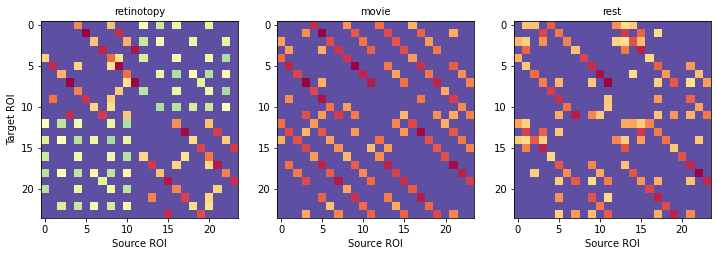

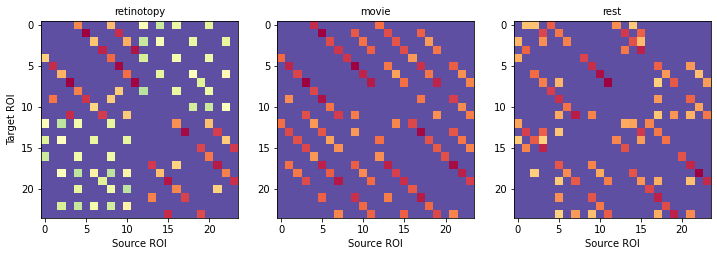

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
prctl = 90

EC_task = np.mean(EC_pool[:,tsk_a,:],axis=1).squeeze()
EC_pca = pca.fit_transform(EC_task.T)
EC_pca_score = pca.score_samples(EC_task.T)
X  = np.fliplr(callosal)*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
intra  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
X  = callosal*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
callo  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
A1 = intra + callo


EC_task = np.mean(EC_pool[:,tsk_b,:],axis=1).squeeze()
EC_pca = pca.fit_transform(EC_task.T)
EC_pca_score = pca.score_samples(EC_task.T)
X  = np.fliplr(callosal)*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
intra  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
X  = callosal*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
callo  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
A2 = intra + callo


EC_task = np.mean(EC_pool[:,tsk_c,:],axis=1).squeeze()
EC_pca = pca.fit_transform(EC_task.T)
EC_pca_score = pca.score_samples(EC_task.T)
X  = np.fliplr(callosal)*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
intra  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
X  = callosal*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
callo  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
A3 = intra + callo


fig, axs = plt.subplots(1,3,figsize=(12, 12))
#fig.tight_layout()
# ============================================================================
plt.sca(axs[0])
plt.imshow(A1, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('retinotopy', fontsize=10)

plt.sca(axs[1])
plt.imshow(A2, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
#plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('movie', fontsize=10)


plt.sca(axs[2])
plt.imshow(A3, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
#plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('rest', fontsize=10)
plt.show()



EC_links  = np.empty((3,EC_normed.shape[2]**2))
EC_links[0,:] = A1.flatten()
EC_links[1,:] = A2.flatten()
EC_links[2,:] = A3.flatten()
# Save results
fname = '/home/nicogravel/Laminar_VisualFieldMapping/' + 'EC_7HCP_links_90.mat'
sio.savemat(fname, {'EC_links': EC_links})

prctl = 92

EC_task = np.mean(EC_pool[:,tsk_a,:],axis=1).squeeze()
EC_pca = pca.fit_transform(EC_task.T)
EC_pca_score = pca.score_samples(EC_task.T)
X  = np.fliplr(callosal)*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
intra  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
X  = callosal*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
callo  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
A1 = intra + callo


EC_task = np.mean(EC_pool[:,tsk_b,:],axis=1).squeeze()
EC_pca = pca.fit_transform(EC_task.T)
EC_pca_score = pca.score_samples(EC_task.T)
X  = np.fliplr(callosal)*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
intra  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
X  = callosal*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
callo  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
A2 = intra + callo


EC_task = np.mean(EC_pool[:,tsk_c,:],axis=1).squeeze()
EC_pca = pca.fit_transform(EC_task.T)
EC_pca_score = pca.score_samples(EC_task.T)
X  = np.fliplr(callosal)*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
intra  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
X  = callosal*EC_pca[:,0].reshape((24, 24))
X  = X > np.percentile(X.flatten(),prctl)
callo  = X*(np.mean(EC_task,axis=0).reshape((24, 24)))
A3 = intra + callo


fig, axs = plt.subplots(1,3,figsize=(12, 12))
#fig.tight_layout()
# ============================================================================
plt.sca(axs[0])
plt.imshow(A1, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('retinotopy', fontsize=10)

plt.sca(axs[1])
plt.imshow(A2, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
#plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('movie', fontsize=10)


plt.sca(axs[2])
plt.imshow(A3, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=10)
#plt.ylabel('Target ROI', fontsize=10)
#plt.colorbar()
plt.title('rest', fontsize=10)
plt.show()



EC_links  = np.empty((3,EC_normed.shape[2]**2))
EC_links[0,:] = A1.flatten()
EC_links[1,:] = A2.flatten()
EC_links[2,:] = A3.flatten()
# Save results
fname = '/home/nicogravel/Laminar_VisualFieldMapping/' + 'EC_7HCP_links_92.mat'
sio.savemat(fname, {'EC_links': EC_links})





# Compute task differences

/localscratch/nicogravel/tmp/ipykernel_92647/2705430721.py:137: RuntimeWarning: invalid value encountered in divide
  t_score[i, :] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))
/localscratch/nicogravel/tmp/ipykernel_92647/2705430721.py:169: RuntimeWarning: invalid value encountered in divide
  t_perms[i, :] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))


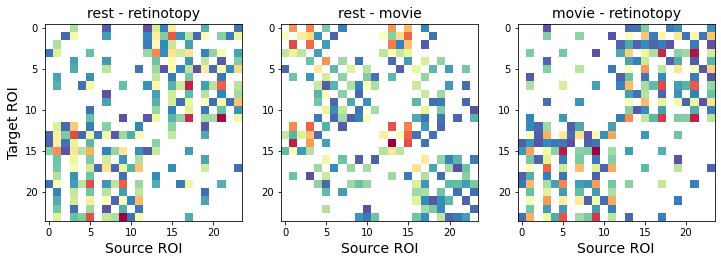

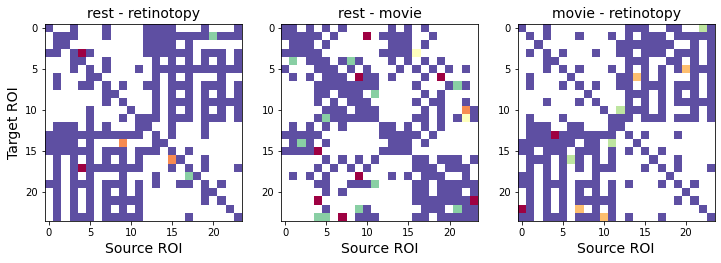

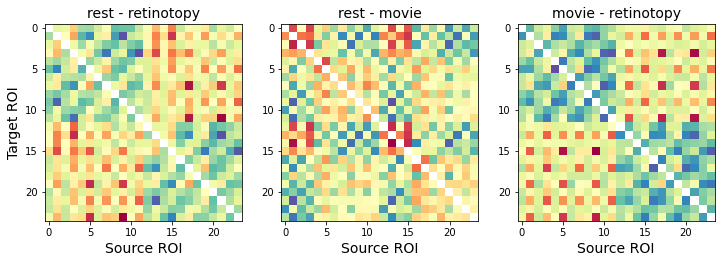

In [21]:
'''
    perm returns: 
        0: Global: array of T values where the observed T values were larger than 1-alpha% of 
            all the null permuted data. Best for data that is 1D or 2D unless 
            you want separate comparisons for each index. 
        1: Part: array of T values where the observed T value was larger than the permuted
            T distributions in the same index point of the array. Very conservative, observed 
            values must be greater than All permuted values in the same index point.
        2: P_array: array showing p values where the observed t values exceeded 1-alpha% 
            of the permuted values at each index point of a multidimensional array. 
            Typical permutation test output, best for multidimensional data where index matters. 
        3: null_Tmax: The single T value from the permuted null distribution that is above 1-alpha 
        4: t_score: array of T values from the observed data.
        5: nullT: list of arrays of T values from the permuted data.
        max_null: identify outliers in null permuted data after ttest
        max_obs: identify outliers in observed data after ttest
            
'''

EC_task_a = np.mean(EC_normed[:,tsk_a,:],axis=1).squeeze()
EC_task_b = np.mean(EC_normed[:,tsk_b,:],axis=1).squeeze()
EC_task_c = np.mean(EC_normed[:,tsk_c,:],axis=1).squeeze()




t_a = perm(EC_task_b, EC_task_a, perms=1000, test='rel', alpha=.005, nan='propagate')
t_b = perm(EC_task_c, EC_task_a, perms=1000, test='rel', alpha=.005, nan='propagate')
t_c = perm(EC_task_c, EC_task_b, perms=1000, test='rel', alpha=.005, nan='propagate')
#t_score = perm(EC_task_a, np.zeros((19,24,24)), perms=1000, test='rel', alpha=.05, nan='propagate')
#import matplotlib.colors as colors

A = t_a[1] 
B = t_b[1]
C = t_c[1]  


fig, axs = plt.subplots(1,3,figsize=(12, 12))
#fig.tight_layout()
# =============================================================================

plt.sca(axs[0])
plt.imshow(B, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('rest - retinotopy', fontsize=14)


plt.sca(axs[1])
plt.imshow(C, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
#plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('rest - movie', fontsize=14)


plt.sca(axs[2])
plt.imshow(A, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
#plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('movie - retinotopy', fontsize=14)
plt.show()


EC_diffs  = np.empty((3,EC_normed.shape[2]**2))
EC_diffs[0,:] = A.flatten()
EC_diffs[1,:] = B.flatten()
EC_diffs[2,:] = C.flatten()

# Save results
fname = '/home/nicogravel/Laminar_VisualFieldMapping/' + 'EC_7HCP_diffs_T_005.mat'

sio.savemat(fname, {'EC_diffs': EC_diffs})


A = t_a[2] 
B = t_b[2]
C = t_c[2]  


fig, axs = plt.subplots(1,3,figsize=(12, 12))
#fig.tight_layout()
# =============================================================================

plt.sca(axs[0])
plt.imshow(B, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('rest - retinotopy', fontsize=14)


plt.sca(axs[1])
plt.imshow(C, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
#plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('rest - movie', fontsize=14)


plt.sca(axs[2])
plt.imshow(A, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
#plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('movie - retinotopy', fontsize=14)
plt.show()


EC_diffs  = np.empty((3,EC_normed.shape[2]**2))
EC_diffs[0,:] = A.flatten()
EC_diffs[1,:] = B.flatten()
EC_diffs[2,:] = C.flatten()

# Save results
fname = '/home/nicogravel/Laminar_VisualFieldMapping/' + 'EC_7HCP_diffs_P_005.mat'

sio.savemat(fname, {'EC_diffs': EC_diffs})

A = t_a[4] 
B = t_b[4]
C = t_c[4]  


fig, axs = plt.subplots(1,3,figsize=(12, 12))
#fig.tight_layout()
# =============================================================================

plt.sca(axs[0])
plt.imshow(B, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('rest - retinotopy', fontsize=14)


plt.sca(axs[1])
plt.imshow(C, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
#plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('rest - movie', fontsize=14)


plt.sca(axs[2])
plt.imshow(A, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
#plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('movie - retinotopy', fontsize=14)
plt.show()


EC_diffs  = np.empty((3,EC_normed.shape[2]**2))
EC_diffs[0,:] = A.flatten()
EC_diffs[1,:] = B.flatten()
EC_diffs[2,:] = C.flatten()

# Save results
fname = '/home/nicogravel/Laminar_VisualFieldMapping/' + 'EC_7HCP_diffs_Tvals.mat'

sio.savemat(fname, {'EC_diffs': EC_diffs})

/localscratch/nicogravel/tmp/ipykernel_203939/2705430721.py:137: RuntimeWarning: invalid value encountered in divide
  t_score[i, :] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))
/localscratch/nicogravel/tmp/ipykernel_203939/2705430721.py:169: RuntimeWarning: invalid value encountered in divide
  t_perms[i, :] = diff.mean(0)/(diff.std(0)/np.sqrt(n_sub))


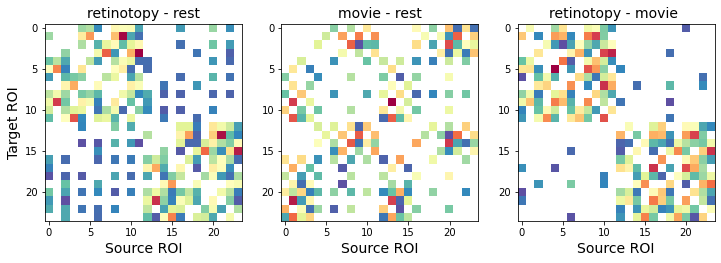

In [8]:
'''
    perm returns: 
        0: Global: array of T values where the observed T values were larger than 1-alpha% of 
            all the null permuted data. Best for data that is 1D or 2D unless 
            you want separate comparisons for each index. 
        1: Part: array of T values where the observed T value was larger than the permuted
            T distributions in the same index point of the array. Very conservative, observed 
            values must be greater than All permuted values in the same index point.
        2: P_array: array showing p values where the observed t values exceeded 1-alpha% 
            of the permuted values at each index point of a multidimensional array. 
            Typical permutation test output, best for multidimensional data where index matters. 
        3: null_Tmax: The single T value from the permuted null distribution that is above 1-alpha 
        4: t_score: array of T values from the observed data.
        5: nullT: list of arrays of T values from the permuted data.
        max_null: identify outliers in null permuted data after ttest
        max_obs: identify outliers in observed data after ttest
            
'''

EC_task_a = np.mean(EC_normed[:,tsk_a,:],axis=1).squeeze()
EC_task_b = np.mean(EC_normed[:,tsk_b,:],axis=1).squeeze()
EC_task_c = np.mean(EC_normed[:,tsk_c,:],axis=1).squeeze()




t_a = perm(EC_task_a, EC_task_b, perms=1000, test='rel', alpha=.005, nan='propagate')
t_b = perm(EC_task_a, EC_task_c, perms=1000, test='rel', alpha=.005, nan='propagate')
t_c = perm(EC_task_b, EC_task_c, perms=1000, test='rel', alpha=.005, nan='propagate')
#t_score = perm(EC_task_a, np.zeros((19,24,24)), perms=1000, test='rel', alpha=.05, nan='propagate')
#import matplotlib.colors as colors

A = t_a[1] 
B = t_b[1]
C = t_c[1]  


fig, axs = plt.subplots(1,3,figsize=(12, 12))
#fig.tight_layout()
# =============================================================================

plt.sca(axs[0])
plt.imshow(B, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('retinotopy - rest', fontsize=14)


plt.sca(axs[1])
plt.imshow(C, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
#plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('movie - rest', fontsize=14)


plt.sca(axs[2])
plt.imshow(A, cmap='Spectral_r')
plt.xlabel('Source ROI', fontsize=14)
#plt.ylabel('Target ROI', fontsize=14)
#plt.colorbar()
plt.title('retinotopy - movie ', fontsize=14)
plt.show()


EC_diffs  = np.empty((3,EC_normed.shape[2]**2))
EC_diffs[0,:] = A.flatten()
EC_diffs[1,:] = B.flatten()
EC_diffs[2,:] = C.flatten()

# Save results
fname = '/home/nicogravel/Laminar_VisualFieldMapping/' + 'EC_7HCP_diffs2_T_005.mat'

sio.savemat(fname, {'EC_diffs': EC_diffs})



In [ ]:
https://github.com/hmmlearn/hmmlearn

In [ ]:
https://www.sciencedirect.com/science/article/abs/pii/S1361841513000042?via%3Dihub

In [ ]:
https://github.com/guorongwu